### Import Libraries

In [1]:
# Important important libraries
import pandas as pd
import seaborn as sns

# nltk library
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

### Load Data

In [2]:
# import data
df = pd.read_csv("spam.csv")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# drop irrelevant columns
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'], inplace=True)

In [4]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# I want to rename the colums to spam and text, also replace spam as 1 and ham as 0
# Rename the columns
df.columns = ['spam', 'text']

# Replace 'ham' with 0 and 'spam' with 1 in the 'spam' column
df['spam'] = df['spam'].replace({'ham': 0, 'spam': 1})
df.head()

,spam,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# Check for the number of text we have
print(f"Number of text is {df.shape[0]}")

Number of text is 5572


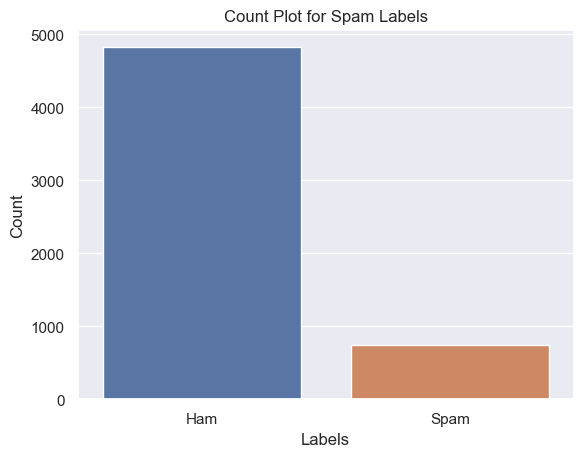

In [7]:
# For better understanding I'm going to plot the count of spam and ham in the data
sns.set(style="darkgrid")

# Create the count plot
ax = sns.countplot(x="spam", data=df)

# Set the labels for the x-axis
ax.set_xticklabels(['Ham', 'Spam'])

# Set the title and labels for the plot
ax.set_title('Count Plot for Spam Labels')
ax.set_xlabel('Labels')
ax.set_ylabel('Count')

# Show the plot
plt.show()

In [8]:
df['spam'].value_counts()

0    4825
1     747
Name: spam, dtype: int64

From the above we can see that we have a significantly higher number of 'Ham' messages compared to 'Spam' messages. This imbalance can lead to a biased model when training a classifier.
I'm going to fix this using Synthetic Minority Over-sampling Technique (SMOTE) to oversample after preprocessing

### pre-processing

In [9]:
# Create a function to pre_process text
def pre_process(text):
    # Tokenize the text
    words = word_tokenize(text)

    # Convert words to lowercase
    words = [word.lower() for word in words]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Remove punctuation
    words = [word for word in words if word not in string.punctuation]

    # Perform stemming
    ps = PorterStemmer()
    words = [ps.stem(word) for word in words]
    
    # Join the words back into a single string
    preprocessed_text = ' '.join(words)

    return preprocessed_text

In [10]:
df['preprocessed_text'] = df['text'].apply(pre_process)
df.head()

,spam,text,preprocessed_text
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi .. avail bugi n great wo...
1,0,Ok lar... Joking wif u oni...,ok lar ... joke wif u oni ...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,u dun say earli hor ... u c alreadi say ...
4,0,"Nah I don't think he goes to usf, he lives aro...",nah n't think goe usf live around though


In [11]:
print(df['text'][0])
print(df['preprocessed_text'][0])

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
go jurong point crazi .. avail bugi n great world la e buffet ... cine got amor wat ...


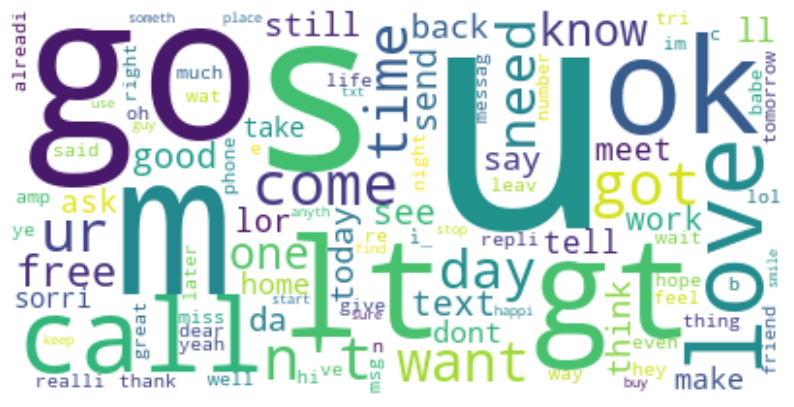

In [12]:
# Visualizing the pre_processed text using wordcloud. Wordcloud shows the most frequent word in the data

# Combine all the preprocessed text into a single string
all_text = ' '.join(df['preprocessed_text'])

# Generate the word cloud
wordcloud = WordCloud(
    background_color='white', max_words=100, contour_width=3, contour_color='steelblue'
).generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [13]:
# Split the dataset into features (X) and target (y)
X = df['preprocessed_text']
y = df['spam']

In [14]:
# Split the dataset into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Transform the preprocessed text data into a numerical format using TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [16]:
print(X_train_vectorized.shape)
print(X_test_vectorized.shape)

(4457, 6592)
(1115, 6592)


In [17]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_vectorized, y_train)

In [18]:
print(X_train_balanced.shape)

(7720, 6592)


### Model

In [19]:
# Train the logistic regression model
clf = LogisticRegression(random_state=42)
clf.fit(X_train_balanced, y_train_balanced)

LogisticRegression(random_state=42)

In [20]:
# Make predictions on the test set
y_pred = clf.predict(X_test_vectorized)

In [21]:
# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       965
           1       0.93      0.91      0.92       150

    accuracy                           0.98      1115
   macro avg       0.96      0.95      0.95      1115
weighted avg       0.98      0.98      0.98      1115



In [22]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[954  11]
 [ 13 137]]


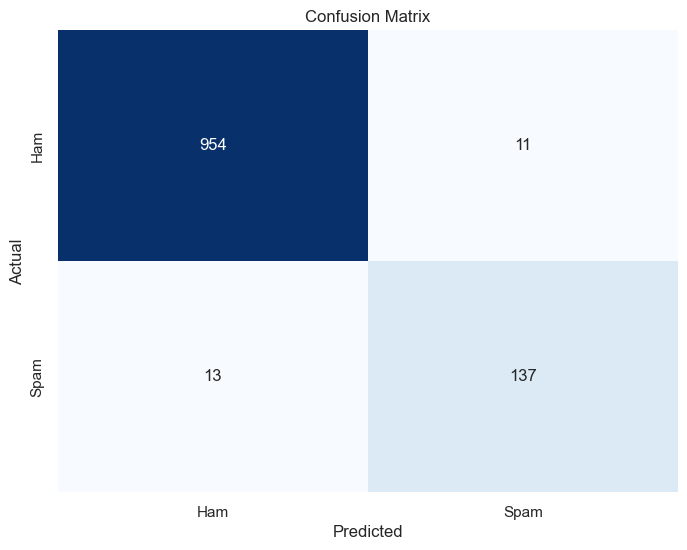

In [23]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap plot using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])

# Set the title and labels for the plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.show()

In [24]:
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

Accuracy Score:
0.97847533632287
